# Masks
Functions to streamline creating masks from minecraft videos

In [7]:
import os
import shutil
from pathlib import Path
from glob import glob

import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
# from videoreader import VideoReader

from mapping import mapping, mapping_view

In [2]:
def get_mask(image_rgb):
    image_h = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2HSV)[..., 0]
    colors_h = np.array(list(mapping.values()))[..., 0]
    distances = []
    for color_h in colors_h:
        distance = np.abs(image_h-color_h)
        distances.append(distance)
    distances = np.array(distances)
    mask = np.argmin(distances, axis=0)
    return mask

In [3]:
def create_readable_mask(mask):
    ref_colors = np.array(list(mapping.values()))
    mask_colored_hsv = ref_colors[mask]
    mask_colored_rgb = cv2.cvtColor(mask_colored_hsv.astype(np.uint8), cv2.COLOR_HSV2RGB)
    return mask_colored_rgb

## Quick Tests

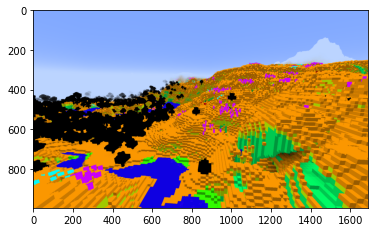

In [106]:
image_rgb = cv2.imread('../images/screen_colors_3.png')[..., ::-1]
plt.imshow(image_rgb);

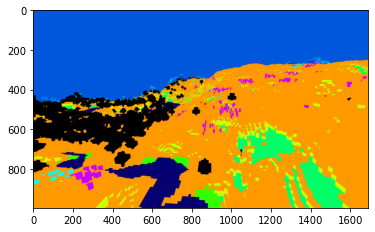

In [107]:
mask = get_mask(image_rgb)
readable_mask = create_readable_mask(mask)
plt.imshow(readable_mask)

## Converting videos

In [4]:
def extract_frames_from_video(video_path, output_directory, size, nn_inter=False):
    video = VideoReader(video_path)
    os.makedirs(output_directory, exist_ok=True)
    interpolation = cv2.INTER_NEAREST if nn_inter else cv2.INTER_LINEAR 

    for frame_no, frame in tqdm(enumerate(video), total=len(video)):
        frame = cv2.resize(frame, size, interpolation=interpolation)
        
        frame_path = os.path.join(output_directory, f"img_{frame_no:04d}.png")
        cv2.imwrite(frame_path, frame)
        
    video.close()

In [5]:
def create_masks(colored_dir, masks_dir):
    colored_dir = Path(colored_dir)
    masks_dir = Path(masks_dir)
    
    masks_dir.mkdir(parents=True, exist_ok=True)
    
    paths = list(colored_dir.glob('*.png'))
    for path in tqdm(paths):
        colored = cv2.imread(str(path))[..., ::-1]
        mask = get_mask(colored)
        cv2.imwrite(str(masks_dir / path.name), mask)

In [6]:
def create_readable_masks(masks_dir, readable_masks_dir):
    masks_dir = Path(masks_dir)
    readable_masks_dir = Path(readable_masks_dir)
    
    readable_masks_dir.mkdir(parents=True, exist_ok=True)
    
    paths = list(masks_dir.glob('*.png'))
    for path in tqdm(paths):
        mask = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
        readable_mask = create_readable_mask(mask)
        cv2.imwrite(str(readable_masks_dir / path.name), readable_mask[..., ::-1])

In [178]:
id = 20

In [179]:
# minecraft
extract_frames_from_video(f'../data/{id}/minecraft.avi', f'../data/{id}/minecraft', size=(256, 256), nn_inter=False)

  0%|          | 0/1804 [00:00<?, ?it/s]

100%|██████████| 1804/1804 [00:08<00:00, 219.24it/s]


In [180]:
# colored
extract_frames_from_video(f'../data/{id}/colored.avi', f'../data/{id}/colored', size=(256, 256), nn_inter=True)

  0%|          | 0/1804 [00:00<?, ?it/s]

100%|██████████| 1804/1804 [00:06<00:00, 284.52it/s]


In [181]:
create_masks(f'../data/{id}/colored', f'../data/{id}/masks')

100%|██████████| 1804/1804 [00:17<00:00, 101.16it/s]


In [182]:
create_readable_masks(f'../data/{id}/masks', f'../data/{id}/readable_masks')

100%|██████████| 1804/1804 [00:10<00:00, 179.52it/s]


## Tests

In [183]:
def compare_images(id, frame):
    minecraft_path = f'../data/{id}/minecraft/img_{frame:04d}.png'
    colored_path = f'../data/{id}/colored/img_{frame:04d}.png'
    mask_path = f'../data/{id}/readable_masks/img_{frame:04d}.png'
    
    minecraft_img = cv2.imread(minecraft_path)
    colored_img = cv2.imread(colored_path)
    mask_img = cv2.imread(mask_path)
    
    joined = np.concatenate([minecraft_img, colored_img, mask_img], axis=1)
    
    fig, ax = plt.subplots(1, 1, figsize = (20, 5))
    ax.imshow(joined[..., ::-1])
    
    combined = (minecraft_img*0.5 + mask_img*0.5).astype(np.uint8)
    fig, ax = plt.subplots(1, 1, figsize = (10, 10))
    ax.imshow(combined[..., ::-1])

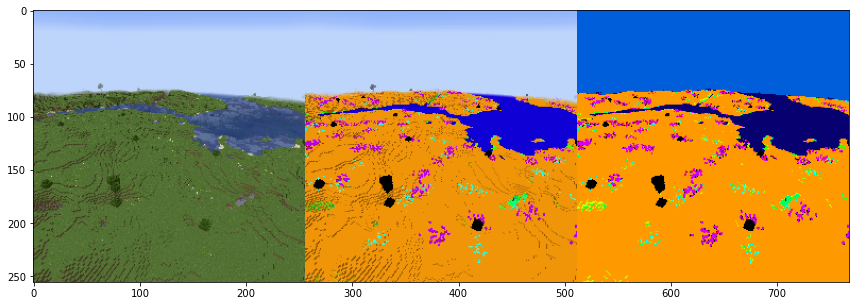

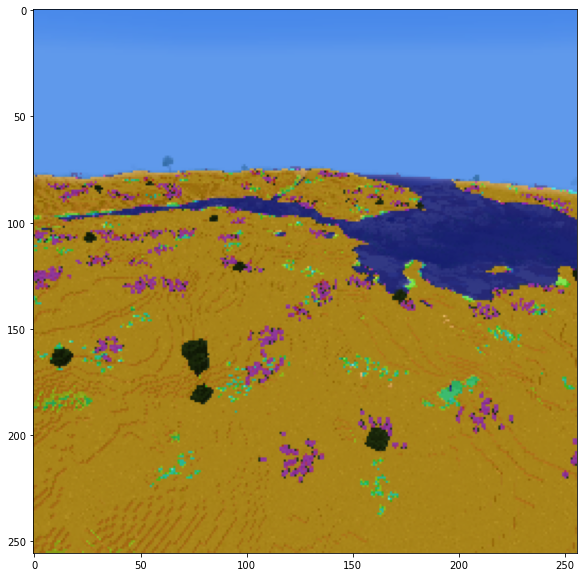

In [184]:
compare_images(id, 1803)

# Creating merged dataset

In [8]:
SRC_PATH = Path('../data')
DST_PATH = Path('../dataset')

src_mc_paths = list(SRC_PATH.glob('*/minecraft/*.png'))
src_mask_paths = [path.parent.parent / 'masks' / path.name for path in src_mc_paths]

src_paths = list(zip(src_mc_paths, src_mask_paths))

for idx, (src_mc_path, src_mask_path) in tqdm(enumerate(src_paths), total=len(src_paths)):
    dst_mc_path = DST_PATH / 'minecraft' / f'{idx:05}.png'
    dst_mask_path = DST_PATH / 'masks' / f'{idx:05}.png'
    
    shutil.copyfile(str(src_mc_path), str(dst_mc_path))
    shutil.copyfile(str(src_mask_path), str(dst_mask_path))

100%|██████████| 10405/10405 [00:01<00:00, 8183.96it/s]
